In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm

In [2]:
# Reproducibility
SEED=1
torch.manual_seed(SEED)
np.random.seed(SEED)
pyro.set_rng_seed(SEED)

In [3]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [4]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())
# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# Point estimate NN
net = NN(28*28, 1024, 10)

In [5]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y)

In [6]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias": pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias": pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [7]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [8]:
# Train with SVI
for epoch in range(10):
    loss = 0.
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        loss += svi.step(images, labels)
    loss /= len(train_loader.dataset)
    print("Epoch %g: Loss = %g" % (epoch, loss))

/usr/local/lib/python3.7/site-packages/pyro/primitives.py:451: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
Epoch 0: Loss = 2067.74
Epoch 1: Loss = 364.151
Epoch 2: Loss = 157.279
Epoch 3: Loss = 109.82
Epoch 4: Loss = 95.9101
Epoch 5: Loss = 90.0523
Epoch 6: Loss = 87.2406
Epoch 7: Loss = 86.3989
Epoch 8: Loss = 86.0325
Epoch 9: Loss = 85.5419


In [16]:
# Sample k models from the posterior
K = 100
sampled_models = [guide(None, None) for i in range(K)]

In [17]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [18]:
# Get a batch and flatten the input
images, targets = next(iter(test_loader))
images = images.reshape(-1, 28*28)

In [26]:
targets

tensor([4])

In [19]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, saliency, eps = 0.18):
    fool = 0
    for k in range(K):
        sm = sampled_models[k]
        # Forward pass on sampled model k
        output = sm(images)
        output = torch.nn.LogSoftmax(dim=-1)(output)
        old_class = torch.argmax(output).item()
        # One step Target Class Method (OTCM); saliency is noise
        new_images = torch.clamp(images.clone()-eps*saliency, 0, 1)
        # Forward pass again on adv. example
        output = sm(new_images)
        output = torch.nn.LogSoftmax(dim=-1)(output)
        new_class = torch.argmax(output).item()
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/K

In [20]:
# Collect noises (saliencies)
saliencies = []
how_many_fooled = []
torch.set_printoptions(sci_mode=False)
for k in range(100):
    sm = sampled_models[k]
    # Set requires_grad to True
    images.grad = None
    images.requires_grad = True
    # Forward pass
    output = sm(images)
    sm.zero_grad()
    output = torch.nn.LogSoftmax(dim=-1)(output)
    old_class = torch.argmax(output).item()
    # Compute loss w.r.t. target class 1 (an incorrect class)
    # Note that we just have to ensure this class is different from targets
    loss = torch.nn.NLLLoss()(output, torch.tensor([1]))
    loss.backward()
    # Compute adversarial example
    otcm_grad = images.grad.clone()
    new_images = torch.clamp(images.clone()-0.18*images.grad.sign(), 0, 1)
    # Forward pass on adv. example
    output = sm(new_images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    new_class = torch.argmax(output).item()
    if old_class != new_class:
        # How many models can this adv. example fool?
        how_many_fooled += [how_many_can_it_fool(sampled_models, images.grad.sign(), eps=0.18)]
        saliencies += [otcm_grad.sign().view(28, 28)]

In [21]:
# distributional saliency map
saliencies = torch.stack(saliencies)
print(saliencies.shape)
newsaliency = torch.zeros(28, 28)
for i in range(28):
    for j in range(28):
        # choose median perturbation
        newsaliency[i, j] = np.percentile(saliencies[:, i, j].numpy(), 50)

torch.Size([100, 28, 28])


In [23]:
print(how_many_can_it_fool(sampled_models, newsaliency.flatten(), eps=0.18))
new_images = torch.clamp(images.clone()-0.18*newsaliency.flatten(), 0, 1)

0.74


In [24]:
how_many_fooled

[0.29,
 0.19,
 0.29,
 0.22,
 0.25,
 0.23,
 0.15,
 0.29,
 0.24,
 0.21,
 0.14,
 0.2,
 0.19,
 0.28,
 0.19,
 0.12,
 0.15,
 0.17,
 0.28,
 0.09,
 0.15,
 0.17,
 0.23,
 0.29,
 0.16,
 0.22,
 0.23,
 0.28,
 0.16,
 0.25,
 0.12,
 0.17,
 0.25,
 0.2,
 0.21,
 0.26,
 0.17,
 0.24,
 0.26,
 0.34,
 0.22,
 0.24,
 0.23,
 0.25,
 0.34,
 0.26,
 0.26,
 0.18,
 0.32,
 0.25,
 0.14,
 0.24,
 0.15,
 0.16,
 0.24,
 0.23,
 0.16,
 0.15,
 0.15,
 0.24,
 0.27,
 0.19,
 0.2,
 0.25,
 0.14,
 0.24,
 0.2,
 0.09,
 0.26,
 0.3,
 0.27,
 0.22,
 0.22,
 0.2,
 0.25,
 0.32,
 0.25,
 0.21,
 0.17,
 0.3,
 0.14,
 0.13,
 0.34,
 0.23,
 0.24,
 0.22,
 0.18,
 0.23,
 0.22,
 0.15,
 0.2,
 0.17,
 0.17,
 0.28,
 0.23,
 0.19,
 0.2,
 0.2,
 0.31,
 0.12]

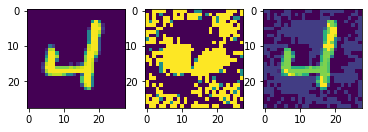

In [25]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((newsaliency*0.18).reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(28, 28).detach().numpy())
plt.show()